# Importing Needed Libraries

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau  
from keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import LearningRateScheduler  
from sklearn.model_selection import KFold  

# Reading The Data

In [2]:
df= pd.read_table("C:\\Users\\Hp\\Downloads\\diabetes.txt", names = ['id', 'date', 'time', 'code', 'value'])
df

,id,date,time,code,value
0,1,04-21-1991,9:09,58,100
1,1,04-21-1991,9:09,33,009
2,1,04-21-1991,9:09,34,013
3,1,04-21-1991,17:08,62,119
4,1,04-21-1991,17:08,33,007
...,...,...,...,...,...
29325,70,05-09-1989,08:00,33,001
29326,70,05-09-1989,08:00,34,007
29327,70,05-10-1989,08:00,34,007
29328,70,05-11-1989,08:00,34,007


# 2. Preprocess the Data

## a.Filter and Clean Data

In [3]:
df.dtypes

id        int64
date     object
time     object
code      int64
value    object
dtype: object

###
Cannot convert values to_numeric() here because some of them are things like "hi" and "lo". Need to filter down to blood glucose measurements first.

Key to code fields below. Note that we have categorical variables in this dataset (hypoglycemic symptoms, etc.). The Code field is deciphered as follows:

33 = Regular insulin dose

34 = NPH insulin dose

35 = UltraLente insulin dose

48 = Unspecified blood glucose measurement

57 = Unspecified blood glucose measurement

58 = Pre-breakfast blood glucose measurement

59 = Post-breakfast blood glucose measurement

60 = Pre-lunch blood glucose measurement

61 = Post-lunch blood glucose measurement

62 = Pre-supper blood glucose measurement

63 = Post-supper blood glucose measurement

64 = Pre-snack blood glucose measurement

65 = Hypoglycemic symptoms

66 = Typical meal ingestion

67 = More-than-usual meal ingestion

68 = Less-than-usual meal ingestion

69 = Typical exercise activity

70 = More-than-usual exercise activity

71 = Less-than-usual exercise activity

72 = Unspecified special event

### Filter down to blood glucose measurements only.

In [4]:
blood_glucose = df[(df['code'] >= 58) & (df['code'] <= 68)]
blood_glucose.head()

,id,date,time,code,value
0,1,04-21-1991,9:09,58,100
3,1,04-21-1991,17:08,62,119
6,1,04-22-1991,7:35,58,216
10,1,04-22-1991,16:56,62,211
12,1,04-23-1991,7:25,58,257


In [5]:
# Convert 'value' to numeric, handle non-numeric values as NaN
blood_glucose['value'] = pd.to_numeric(blood_glucose['value'], errors='coerce')

C:\Users\Hp\AppData\Local\Temp\ipykernel_12864\24648204.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blood_glucose['value'] = pd.to_numeric(blood_glucose['value'], errors='coerce')


In [6]:
blood_glucose = blood_glucose[blood_glucose['value'].notnull()]

In [7]:
meal_context_map = {
    58: 'pre_breakfast', 59: 'post_breakfast',
    60: 'pre_lunch', 61: 'post_lunch',
    62: 'pre_supper', 63: 'post_supper',
    64: 'pre_snack', 65: 'hypoglycemic_symptoms',
    66: 'typical_meal', 67: 'large_meal', 68: 'small_meal'
}

# Add meal context column
blood_glucose['meal_context'] = blood_glucose['code'].map(meal_context_map)

In [8]:
# Step 1: Combine 'date' and 'time' into a single 'datetime' column without specifying format
blood_glucose['datetime'] = pd.to_datetime(
    blood_glucose['date'] + ' ' + blood_glucose['time'], errors='coerce'
)

# Check for any failed conversions
print(blood_glucose[blood_glucose['datetime'].isna()])

# # Step 2: Extract the hour from the 'datetime' column
# blood_glucose['hour'] = blood_glucose['datetime'].dt.hour
blood_glucose

       id        date    time  code  value   meal_context datetime
6505   20  06-31-1991   07:50    58  149.0  pre_breakfast      NaT
6508   20  06-31-1991   13:30    60  162.0      pre_lunch      NaT
6510   20  06-31-1991   19:45    62  213.0     pre_supper      NaT
28070  67  04-09-1991   56:35    58  237.0  pre_breakfast      NaT
28171  67  04-21-1991  188:00    62  128.0     pre_supper      NaT


,id,date,time,code,value,meal_context,datetime
0,1,04-21-1991,9:09,58,100.0,pre_breakfast,1991-04-21 09:09:00
3,1,04-21-1991,17:08,62,119.0,pre_supper,1991-04-21 17:08:00
6,1,04-22-1991,7:35,58,216.0,pre_breakfast,1991-04-22 07:35:00
10,1,04-22-1991,16:56,62,211.0,pre_supper,1991-04-22 16:56:00
12,1,04-23-1991,7:25,58,257.0,pre_breakfast,1991-04-23 07:25:00
...,...,...,...,...,...,...,...
29302,70,05-05-1989,08:00,58,134.0,pre_breakfast,1989-05-05 08:00:00
29309,70,05-06-1989,18:00,62,378.0,pre_supper,1989-05-06 18:00:00
29314,70,05-07-1989,12:00,60,151.0,pre_lunch,1989-05-07 12:00:00
29318,70,05-08-1989,08:00,58,248.0,pre_breakfast,1989-05-08 08:00:00


In [9]:
# Vectorized classification
conditions = [
    # Post-meal
    (blood_glucose['code'].isin([59, 61, 63]) & (blood_glucose['value'] >= 300)),
    (blood_glucose['code'].isin([59, 61, 63]) & (140 <= blood_glucose['value']) & (blood_glucose['value'] <= 220)),
    (blood_glucose['code'].isin([59, 61, 63]) & (90 <= blood_glucose['value']) & (blood_glucose['value'] < 140)),
    (blood_glucose['code'].isin([59, 61, 63]) & (80 <= blood_glucose['value']) & (blood_glucose['value'] < 90)),
    # Pre-meal
    (blood_glucose['code'].isin([58, 60, 62]) & (blood_glucose['value'] >= 200)),
    (blood_glucose['code'].isin([58, 60, 62]) & (130 <= blood_glucose['value']) & (blood_glucose['value'] < 200)),
    (blood_glucose['code'].isin([58, 60, 62]) & (90 <= blood_glucose['value']) & (blood_glucose['value'] < 130)),
    (blood_glucose['code'].isin([58, 60, 62]) & (70 <= blood_glucose['value']) & (blood_glucose['value'] < 90)),
    # Longer durations
    (blood_glucose['code'].isin([64, 66, 67, 68]) & (blood_glucose['value'] >= 180)),
    (blood_glucose['code'].isin([64, 66, 67, 68]) & (120 <= blood_glucose['value']) & (blood_glucose['value'] < 180)),
    (blood_glucose['code'].isin([64, 66, 67, 68]) & (80 <= blood_glucose['value']) & (blood_glucose['value'] < 120)),
    (blood_glucose['code'].isin([64, 66, 67, 68]) & (60 <= blood_glucose['value']) & (blood_glucose['value'] < 80)),
]

choices = [
    'Dangerous', 'High', 'Normal', 'Low',
    'Dangerous', 'High', 'Normal', 'Low',
    'Dangerous', 'High', 'Normal', 'Low'
]

blood_glucose['classification'] = np.select(conditions, choices, default='Dangerous')

# Duration calculation
blood_glucose['time_since_start'] = (blood_glucose['datetime'] - blood_glucose['datetime'].min()).dt.total_seconds() / 3600

# Event detection
threshold = 180  # Define your threshold
blood_glucose['event'] = (blood_glucose['value'] >= threshold).astype(int)

# Check for missing values
print("Missing values:")
print(blood_glucose.isnull().sum())

# Handle missing data by filling or interpolating if necessary
blood_glucose = blood_glucose.fillna(method='ffill')  # Example of forward fill

# Display key results
print(blood_glucose[['datetime', 'value', 'code', 'classification', 'time_since_start', 'event']].head())


Missing values:
id                  0
date                0
time                0
code                0
value               0
meal_context        0
datetime            5
classification      0
time_since_start    5
event               0
dtype: int64
              datetime  value  code classification  time_since_start  event
0  1991-04-21 09:09:00  100.0    58         Normal      26881.150000      0
3  1991-04-21 17:08:00  119.0    62         Normal      26889.133333      0
6  1991-04-22 07:35:00  216.0    58      Dangerous      26903.583333      1
10 1991-04-22 16:56:00  211.0    62      Dangerous      26912.933333      1
12 1991-04-23 07:25:00  257.0    58      Dangerous      26927.416667      1


C:\Users\Hp\AppData\Local\Temp\ipykernel_12864\603743617.py:40: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  blood_glucose = blood_glucose.fillna(method='ffill')  # Example of forward fill


In [10]:
# Fixing 'datetime' column
# Forward-fill missing values
blood_glucose['datetime'] = blood_glucose['datetime'].ffill()

# Recompute 'time_since_start' after fixing 'datetime'
blood_glucose['time_since_start'] = (blood_glucose['datetime'] - blood_glucose['datetime'].min()).dt.total_seconds() / 3600




# Final check for any remaining NaNs
print("Remaining missing values:")
print(blood_glucose.isnull().sum())


Remaining missing values:
id                  0
date                0
time                0
code                0
value               0
meal_context        0
datetime            0
classification      0
time_since_start    0
event               0
dtype: int64


In [11]:
blood_glucose = blood_glucose.set_index('datetime')
blood_glucose

,id,date,time,code,value,meal_context,classification,time_since_start,event
datetime,,,,,,,,,
1991-04-21 09:09:00,1,04-21-1991,9:09,58,100.0,pre_breakfast,Normal,26881.150000,0
1991-04-21 17:08:00,1,04-21-1991,17:08,62,119.0,pre_supper,Normal,26889.133333,0
1991-04-22 07:35:00,1,04-22-1991,7:35,58,216.0,pre_breakfast,Dangerous,26903.583333,1
1991-04-22 16:56:00,1,04-22-1991,16:56,62,211.0,pre_supper,Dangerous,26912.933333,1
1991-04-23 07:25:00,1,04-23-1991,7:25,58,257.0,pre_breakfast,Dangerous,26927.416667,1
...,...,...,...,...,...,...,...,...,...
1989-05-05 08:00:00,70,05-05-1989,08:00,58,134.0,pre_breakfast,High,9696.000000,0
1989-05-06 18:00:00,70,05-06-1989,18:00,62,378.0,pre_supper,Dangerous,9730.000000,1
1989-05-07 12:00:00,70,05-07-1989,12:00,60,151.0,pre_lunch,High,9748.000000,0


In [12]:
blood_glucose=blood_glucose.drop(['date', 'time'], axis=1)

In [13]:
blood_glucose.head()

,id,code,value,meal_context,classification,time_since_start,event
datetime,,,,,,,
1991-04-21 09:09:00,1,58,100.0,pre_breakfast,Normal,26881.150000,0
1991-04-21 17:08:00,1,62,119.0,pre_supper,Normal,26889.133333,0
1991-04-22 07:35:00,1,58,216.0,pre_breakfast,Dangerous,26903.583333,1
1991-04-22 16:56:00,1,62,211.0,pre_supper,Dangerous,26912.933333,1
1991-04-23 07:25:00,1,58,257.0,pre_breakfast,Dangerous,26927.416667,1


### Choosing Prediction Column

In [14]:
dataset = blood_glucose["value"]
dataset = pd.DataFrame(dataset)

data = dataset.values

data.shape

(11498, 1)

### Normalizing Data

In [15]:
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data).reshape(-1, 1))

### Splitting the Data

In [16]:
# 75% to Train , 25% to Test
train_size = int(len(data)*.75)
test_size = len(data) - train_size

print("Train Size :",train_size,"Test Size :",test_size)

train_data = scaled_data[ :train_size , 0:1 ]
test_data = scaled_data[ train_size-7: , 0:1 ]

Train Size : 8623 Test Size : 2875


In [17]:
train_data.shape, test_data.shape

((8623, 1), (2882, 1))

### Creating training set

In [18]:
# Creating a Training set with 60 time-steps and 1 output
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-7:i, 0])
    y_train.append(train_data[i, 0])

In [19]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [20]:
# Reshaping the input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [21]:
x_train.shape , y_train.shape

((8563, 7, 1), (8563,))

#  GRUs & LSTM Model

In [22]:
from tensorflow.keras.layers import GRU, Dense, Dropout  

# Define the Model with Both GRU and LSTM  
def create_model():  
    model = Sequential()  
    model.add(GRU(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))  
    model.add(Dropout(0.3))  
    model.add(LSTM(100, return_sequences=True))  
    model.add(Dropout(0.3))  
    model.add(GRU(70, return_sequences=False))  
    model.add(Dropout(0.3))  
    model.add(Dense(1))  
    model.compile(optimizer='adam', loss='mean_squared_error')  
    return model  
 
model = create_model()  


# Compile the model  
model.compile(optimizer='adam', loss='mean_squared_error')  
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 7, 100)            30900     
                                                                 
 dropout (Dropout)           (None, 7, 100)            0         
                                                                 
 lstm (LSTM)                 (None, 7, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 7, 100)            0         
                                                                 
 gru_1 (GRU)                 (None, 70)                36120     
                                                                 
 dropout_2 (Dropout)         (None, 70)                0         
                                                                 
 dense (Dense)               (None, 1)                 7

### Model Training

In [23]:
# Early stopping and learning rate reduction  
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)  



# Fit the model with callbacks  
history = model.fit(x_train, y_train,  
                    validation_split=0.2,  
                    epochs=100, 
                    batch_size=32,  
                    callbacks=[early_stopping, reduce_lr])  

Epoch 1/100
215/215 [==============================] - 8s 17ms/step - loss: 0.0311 - val_loss: 0.0246 - lr: 0.0010
Epoch 2/100
215/215 [==============================] - 3s 13ms/step - loss: 0.0293 - val_loss: 0.0257 - lr: 0.0010
Epoch 3/100
215/215 [==============================] - 3s 13ms/step - loss: 0.0292 - val_loss: 0.0243 - lr: 0.0010
Epoch 4/100
215/215 [==============================] - 3s 14ms/step - loss: 0.0294 - val_loss: 0.0249 - lr: 0.0010
Epoch 5/100
215/215 [==============================] - 3s 13ms/step - loss: 0.0291 - val_loss: 0.0253 - lr: 0.0010
Epoch 6/100
215/215 [==============================] - 3s 14ms/step - loss: 0.0291 - val_loss: 0.0248 - lr: 0.0010
Epoch 7/100
215/215 [==============================] - 3s 13ms/step - loss: 0.0288 - val_loss: 0.0249 - lr: 0.0010
Epoch 8/100
215/215 [==============================] - 3s 15ms/step - loss: 0.0290 - val_loss: 0.0245 - lr: 0.0010
Epoch 9/100
215/215 [==============================] - 3s 15ms/step - loss: 0.02

### Model Evaluation

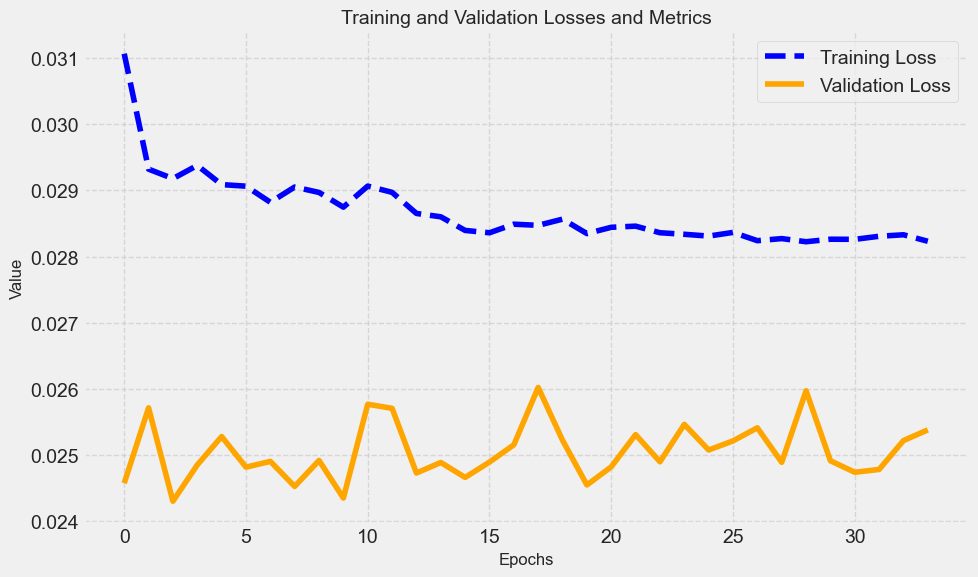

In [24]:
# Plot training and validation losses
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(history.history["loss"], label="Training Loss", color="blue", linestyle="--")
# Plot validation loss
plt.plot(history.history["val_loss"], label="Validation Loss", color="orange", linestyle="-")

# Plot training mean absolute error (if present)
if "mean_absolute_error" in history.history:
    plt.plot(history.history["mean_absolute_error"], label="Training MAE", color="green", linestyle="--")
# Plot validation mean absolute error (if present)
if "val_mean_absolute_error" in history.history:
    plt.plot(history.history["val_mean_absolute_error"], label="Validation MAE", color="red", linestyle="-")

# Add legend, title, labels, and grid
plt.legend(loc="upper right")
plt.title("Training and Validation Losses and Metrics", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


# Predection

### Creating testing set

In [25]:
# Creating a testing set with 60 time-steps and 1 output
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-7:i, 0])
    y_test.append(test_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [26]:
x_test.shape , y_test.shape

((2822, 7, 1), (2822,))

In [27]:
#inverse y_test scaling
predictions = model.predict(x_test)

#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

89/89 [==============================] - 1s 3ms/step


(2822, 1)

### Root mean square error

In [28]:
#inverse y_test scaling
y_test = scaler.inverse_transform([y_test])

RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

2.56

### Mean Absolute Error

In [42]:
MAE=np.mean(np.abs(y_test - predictions )).round(2)
MAE

79.21

In [29]:
preds_acts = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y_test.flatten()})
preds_acts

,Predictions,Actuals
0,137.707092,0.0
1,126.277756,266.0
2,124.050568,91.0
3,127.120552,110.0
4,131.320206,141.0
...,...,...
2817,213.858200,134.0
2818,207.410522,378.0
2819,206.810623,151.0
2820,198.146683,248.0


### Visualize Predictions with The Data

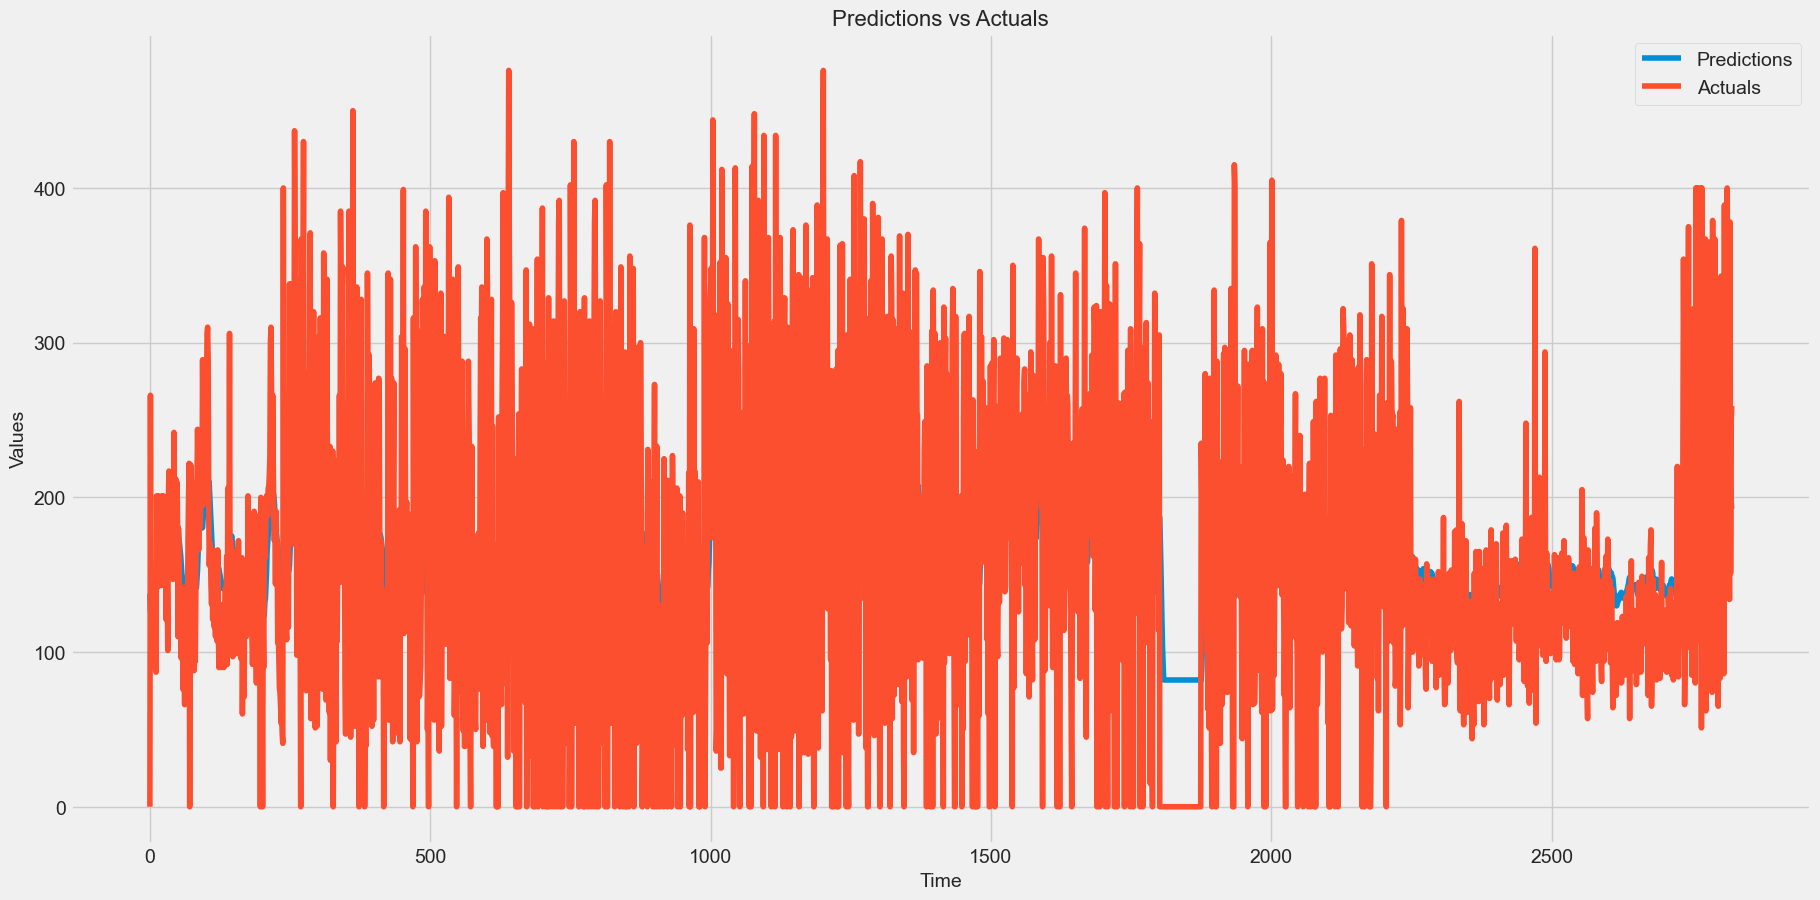

In [30]:

plt.figure(figsize=(20, 10))
plt.plot(preds_acts['Predictions'], label='Predictions')
plt.plot(preds_acts['Actuals'], label='Actuals')

# Adjust font size for legend, title, and labels
plt.legend(fontsize=14)
plt.title('Predictions vs Actuals', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Values', fontsize=14)

plt.show()

# Forecast Next 30 Days

In [31]:
from datetime import timedelta

In [32]:
def insert_end(Xin, new_input):
    timestep = 7
    for i in range(timestep - 1):
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep - 1, :] = new_input
    return Xin

In [33]:
future = 30
forcast = []
Xin = x_test[-1 :, :, :]
time = []
for i in range(0, future):
    out = model.predict(Xin, batch_size=5)
    forcast.append(out[0, 0]) 
    print(forcast)
    Xin = insert_end(Xin, out[0, 0]) 
    time.append(pd.to_datetime(df.index[-1]) + timedelta(days=i))

1/1 [==============================] - 0s 20ms/step
[0.4046794]
1/1 [==============================] - 0s 21ms/step
[0.4046794, 0.39653313]
1/1 [==============================] - 0s 20ms/step
[0.4046794, 0.39653313, 0.3902324]
1/1 [==============================] - 0s 19ms/step
[0.4046794, 0.39653313, 0.3902324, 0.38355213]
1/1 [==============================] - 0s 19ms/step
[0.4046794, 0.39653313, 0.3902324, 0.38355213, 0.3838994]
1/1 [==============================] - 0s 22ms/step
[0.4046794, 0.39653313, 0.3902324, 0.38355213, 0.3838994, 0.37348253]
1/1 [==============================] - 0s 22ms/step
[0.4046794, 0.39653313, 0.3902324, 0.38355213, 0.3838994, 0.37348253, 0.3736498]
1/1 [==============================] - 0s 20ms/step
[0.4046794, 0.39653313, 0.3902324, 0.38355213, 0.3838994, 0.37348253, 0.3736498, 0.36818507]
1/1 [==============================] - 0s 20ms/step
[0.4046794, 0.39653313, 0.3902324, 0.38355213, 0.3838994, 0.37348253, 0.3736498, 0.36818507, 0.3661255]
1/1 [===

In [34]:
time

[Timestamp('1970-01-01 00:00:00.000029329'),
 Timestamp('1970-01-02 00:00:00.000029329'),
 Timestamp('1970-01-03 00:00:00.000029329'),
 Timestamp('1970-01-04 00:00:00.000029329'),
 Timestamp('1970-01-05 00:00:00.000029329'),
 Timestamp('1970-01-06 00:00:00.000029329'),
 Timestamp('1970-01-07 00:00:00.000029329'),
 Timestamp('1970-01-08 00:00:00.000029329'),
 Timestamp('1970-01-09 00:00:00.000029329'),
 Timestamp('1970-01-10 00:00:00.000029329'),
 Timestamp('1970-01-11 00:00:00.000029329'),
 Timestamp('1970-01-12 00:00:00.000029329'),
 Timestamp('1970-01-13 00:00:00.000029329'),
 Timestamp('1970-01-14 00:00:00.000029329'),
 Timestamp('1970-01-15 00:00:00.000029329'),
 Timestamp('1970-01-16 00:00:00.000029329'),
 Timestamp('1970-01-17 00:00:00.000029329'),
 Timestamp('1970-01-18 00:00:00.000029329'),
 Timestamp('1970-01-19 00:00:00.000029329'),
 Timestamp('1970-01-20 00:00:00.000029329'),
 Timestamp('1970-01-21 00:00:00.000029329'),
 Timestamp('1970-01-22 00:00:00.000029329'),
 Timestamp

### Create forecasted dataframe

In [35]:
forcasted_output = np.asanyarray(forcast)   
forcasted_output = forcasted_output.reshape(-1, 1) 
forcasted_output = scaler.inverse_transform(forcasted_output) 

In [36]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output], axis=1)
df_result.columns = "Date", "Forecasted"

In [37]:
df_result

,Date,Forecasted
0,1970-01-01 00:00:00.000029329,192.627396
1,1970-01-02 00:00:00.000029329,188.749771
2,1970-01-03 00:00:00.000029329,185.750626
3,1970-01-04 00:00:00.000029329,182.570816
4,1970-01-05 00:00:00.000029329,182.736115
5,1970-01-06 00:00:00.000029329,177.777679
6,1970-01-07 00:00:00.000029329,177.857315
7,1970-01-08 00:00:00.000029329,175.256088
8,1970-01-09 00:00:00.000029329,174.275742
9,1970-01-10 00:00:00.000029329,173.423141
